In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import cv2
import os
from scipy import signal
import skimage.filters
import matplotlib.pyplot as plt
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,UpSampling2D,InputLayer,Reshape,Activation, BatchNormalization, LeakyReLU
from keras.models import Sequential
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras import activations
from keras import optimizers
from sklearn.model_selection import train_test_split
import tensorflow as tf

## Preprocessing

In [5]:
x_data = []
y_data = []

def loadmydata():
    for item in os.listdir('/content/drive/MyDrive/Explomy/Final_data/x_train'):

        os.chdir('/content/drive/MyDrive/Explomy/Final_data/x_train')
        img = load_img(item)
        #img = img.resize((540,258)) 
        arr = img_to_array(img)
        x_data.append(arr)

        os.chdir('/content/drive/MyDrive/Explomy/Final_data/y_train')
        img = load_img(item)
        #img = img.resize((540,258))
        arr = img_to_array(img)
        y_data.append(arr)  

loadmydata()

x_data = tf.image.rgb_to_grayscale(x_data)
y_data = tf.image.rgb_to_grayscale(y_data)

In [6]:
print(x_data[0].shape, y_data[0].shape)
x_data.shape

(258, 540, 1) (258, 540, 1)


TensorShape([480, 258, 540, 1])

In [7]:
def preprocess(arr):
    arr=np.asarray(arr,dtype="float32")
    arr2=arr/255
    return arr2
        

x_train = preprocess(x_data)
y_train = preprocess(y_data)

In [8]:
x_train.shape

(480, 258, 540, 1)

## Applying Gaussian filter and Adaptive threshold

In [11]:
def adaptive(inp):
    blur = skimage.filters.gaussian(inp, sigma=1)
    t = skimage.filters.threshold_local(blur, 5, offset=0.05)
    mask = inp < t  
    return np.where(mask, inp, 1.0).reshape(258, 540)

In [13]:
x_data_at = []

x_t = np.squeeze(x_train)

for i in range(len(x_train)):
    arr = adaptive(x_t[i])
    x_data_at.append(arr)
    

In [14]:
x_data_at =np.array(x_data_at)
x_data_at.shape

(480, 258, 540)

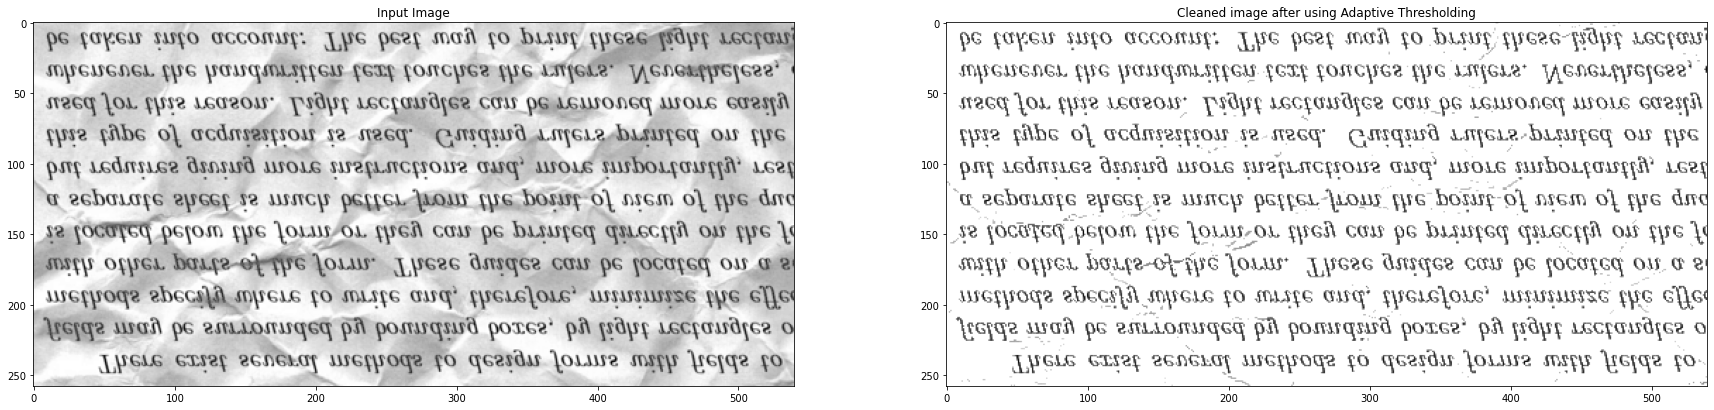

In [18]:
f, axarr = plt.subplots(1,2,figsize=(30,40))
axarr[0].imshow(x_train[5,:,:,0], cmap="gray")
axarr[0].set_title("Input Image")
axarr[1].imshow(x_data_at[5], cmap="gray")
axarr[1].set_title("Cleaned image after using Adaptive Thresholding")
plt.show()

## Applying Median Filter

In [19]:
def medianfilter(inp):
    bg = signal.medfilt2d(inp, 11)
    mask = inp < bg - 0.1
    return np.where(mask, inp, 1.0)

In [20]:
x_data_med = []

x_t = np.squeeze(x_train)

for i in range(len(x_train)):
    arr = medianfilter(x_t[i])
    x_data_med.append(arr)

In [21]:
x_data_med =np.array(x_data_med)
x_data_med.shape

(480, 258, 540)

## Applying Convolutional autoencoders

In [22]:
conv_ae_model = tf.keras.models.load_model('/content/drive/MyDrive/Explomy/my_model.h5')

In [23]:
conv_ae_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 258, 540, 128)     1280      
_________________________________________________________________
batch_normalization_2 (Batch (None, 258, 540, 128)     512       
_________________________________________________________________
activation_2 (Activation)    (None, 258, 540, 128)     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 258, 540, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 129, 270, 128)     0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 129, 270, 64)      73792     
_________________________________________________________________
batch_normalization_3 (Batch (None, 129, 270, 64)     

In [24]:
x_data_cae = []

for i in range(len(x_train)):
    check = x_train[i]
    matrix=conv_ae_model.predict(check.reshape((1,)+check.shape)).reshape(258,540)
    x_data_cae.append(matrix)

In [25]:
x_data_cae =np.array(x_data_cae)
x_data_cae.shape

(480, 258, 540)

## Stacking

In [26]:
data = np.stack((np.squeeze(x_train), x_data_med, x_data_cae, x_data_at), axis=3)
data.shape

(480, 258, 540, 4)

## CNN Stacker

In [27]:
opt = optimizers.RMSprop(learning_rate=0.001) 
model = Sequential()

model.add(Conv2D(64, (3, 3), padding='same',input_shape=(258,540,4),data_format="channels_last"))
model.add(BatchNormalization())
model.add(Activation(activations.relu))

model.add(Conv2D(32, (3, 3), padding='same', ))
model.add(BatchNormalization())
model.add(Activation(activations.relu))

model.add(Conv2D(16, (3, 3), padding='same', ))
model.add(BatchNormalization())
model.add(Activation(activations.relu))

model.add(Conv2D(32, (3, 3), padding='same', ))
model.add(BatchNormalization())
model.add(Activation(activations.relu))

model.add(Conv2D(64, (3, 3), padding='same', ))
model.add(Activation(activations.relu))

model.add(Conv2D(1, (3, 3), activation=tf.keras.backend.sigmoid, padding='same'))
model.compile(loss="mean_squared_error",optimizer=opt, metrics = [tf.keras.metrics.RootMeanSquaredError()])
print(model.summary())

    
model.fit(data,
          y_train,
          epochs = 60,
          batch_size = 7,
          validation_split=0.1,          
          verbose=1) 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 258, 540, 64)      2368      
_________________________________________________________________
batch_normalization (BatchNo (None, 258, 540, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 258, 540, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 258, 540, 32)      18464     
_________________________________________________________________
batch_normalization_1 (Batch (None, 258, 540, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 258, 540, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 258, 540, 16)      4

## Evaluation

In [28]:
x_data_test = []
y_data_test = []

def loadmydatatest():
    for item in os.listdir('/content/drive/MyDrive/Explomy/Final_data/x_test'):

        os.chdir('/content/drive/MyDrive/Explomy/Final_data/x_test')
        img = load_img(item)
        #img = img.resize((540,258)) 
        arr = img_to_array(img)
        x_data_test.append(arr)

        os.chdir('/content/drive/MyDrive/Explomy/Final_data/y_test')
        img = load_img(item)
        #img = img.resize((540,258))
        arr = img_to_array(img)
        y_data_test.append(arr)  

loadmydatatest()

x_data_test = tf.image.rgb_to_grayscale(x_data_test)
y_data_test = tf.image.rgb_to_grayscale(y_data_test)

In [29]:
print(x_data_test[0].shape, y_data_test[0].shape)
x_data_test.shape

(258, 540, 1) (258, 540, 1)


TensorShape([24, 258, 540, 1])

In [30]:
x_test = preprocess(x_data_test)
y_test = preprocess(y_data_test)

In [31]:

from sklearn.metrics import mean_squared_error
rms=0

x_t = np.squeeze(x_test)
y_t = np.squeeze(y_test)

for i in range(len(x_test)):
    check1 = x_test[i]

    arr  = x_t[i] 
    arr1 = adaptive(x_t[i])
    arr2 = medianfilter(x_t[i])
    matrix=conv_ae_model.predict(check1.reshape((1,)+check1.shape)).reshape(258,540)
    check = np.stack((arr, arr2, matrix,arr1), axis=2)

    matrix=model.predict(check.reshape((1,)+check.shape)).reshape(258,540,1)
    matrix = np.squeeze(matrix)
    rms += mean_squared_error(y_t[i], matrix, squared=False)

rms/=len(x_test)
rms

0.01948199428928395